### DFRとVFRの未来の擾乱に対する計画収束速度で比較する

仮説: DFRで運行すると未来の擾乱に対する周りの人（自分の決定に影響を及ぼしうる人）の反応が瞬時にわかるため、VFRと比べた際に擾乱に対する収束速度が高まる。その結果として交通キャパシティが上昇する。

この仮説をシミュレーション実験によって確かめる。

#### 組むべき実験系
- ノイズは1個だけ（複数にも対応できるようにはしているが速度計算周りが怪しい）


In [1]:
import random
import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import pandas as pd
import sys
import copy

sys.path.append("../")
from models import Cars, ReservationTable, DFRSimulation, VFRSimulation
from utils import check_multiple_noise_effect, validate_with_ttc

# ↑↑↑↑↑↑↑↑↑この部分は別セルでも良い↑↑↑↑↑↑↑↑↑

# 初期設定（独立変数群）
CAR_NUM = 50 #時間窓内の車の総数
START_TIME = 0
TOTAL_LENGTH = 1000 # 入り口から出口までの距離 [m]
WAYPOINTS_NUM = 10 #constrained way pointの数
MEAN_SPEED = 20 # 秒速[m/s]として定義
MAX_SPEED = 30 # 秒速[m/s]として定義
MAX_ACC = 3 # m/s^sで定義, maxは0.3gにした
TIME_STEP = 0.1
TOTAL_TIME = 100 # シミュレーション時間

# 研究用のパラメータ
TTC = 1.5 #車間時間を暫定的に定義
COMMUNICATION_SPEED = 0.3
DENSITY = 2 # 台数密度を車間時間として定義
NOISE_FORECAST_TIME = 15 # 何秒後の擾乱を前もって知らせるか. 
NOISE_PERIOD = 5
NOISE_FREQUENCY = 10

def generate_arrival_times(car_num, d, TOTAL_TIME):
    sequence = [random.uniform(0, 3)]
    while len(sequence) < car_num:
        next_value = sequence[-1] + d + random.uniform(0, 2) + 0.2 # これは +0.2しておかないと入り口の時点で弾かれる場合がある
        sequence.append(next_value)
        if next_value > TOTAL_TIME:
            break
    return sequence

arrival_times = generate_arrival_times(CAR_NUM, DENSITY, TOTAL_TIME)
car_params = {"v_mean":MEAN_SPEED, "v_max": MAX_SPEED, "a_max":MAX_ACC, "a_min":MAX_ACC}

def create_noise(current_time):
    if current_time % NOISE_FREQUENCY == 0 and current_time > 0:
        # ノイズを未来に発生させる（この瞬間、だと偶然ハマる車が出てきしまう）
        return {"x": [420, 450], "t": [current_time + NOISE_FORECAST_TIME, current_time + NOISE_FORECAST_TIME + NOISE_PERIOD]}
    # この場合はノイズを発生させない.
    return None

def register_initial_eta(cars):
    for idx, car in enumerate(CARS):
        desired_eta_list = car.create_desired_eta(WAYPOINTS)
        is_valid = reservation_table.validate(desired_eta_list)
        if is_valid:
            reservation_table.register(desired_eta_list)
        else:
            calibration_info = {"desired_list": desired_eta_list}
            calibrated_list, _ = reservation_table.calibrate_list(**calibration_info)
            # print(calibrated_list)
            # print()
            reservation_table.register(calibrated_list)
            car.my_list = calibrated_list

In [2]:
# 従属的に決まるもの
WAYPOINTS = [{"waypoint_idx": i, "x": TOTAL_LENGTH / WAYPOINTS_NUM * (i)} for i in range(WAYPOINTS_NUM+1)]
group_id = 0
arrival_times = [2.325199027775089, 15.073310985213443, 27.454927146921104, 40.928063393970724, 54.179610068636904, 67.34065176988041, 80.29142920666305, 93.117955474138, 106.40594937395332, 101.7]

CARS = [Cars(arrival_time=time, index=index, v_mean=MEAN_SPEED, v_max = MAX_SPEED, a_max=MAX_ACC, a_min=MAX_ACC)
              for index, time in enumerate(arrival_times)]

In [30]:
reservation_table = ReservationTable(waypoints = WAYPOINTS, global_params = {"DESIRED_TTC":TTC})

# 各車がETAを決める部分
register_initial_eta(CARS)

In [31]:
# ここからDFRのシミュレーション
simulation = DFRSimulation(TOTAL_TIME = TOTAL_TIME, TIME_STEP = TIME_STEP, TOTAL_LENGTH = TOTAL_LENGTH, CARS = CARS, \
                          reservation_table = reservation_table, create_noise=create_noise, COMMUNICATION_SPEED=COMMUNICATION_SPEED, DENSITY=DENSITY)
simulation.conduct_simulation(should_plot=True)

Simulation Progress DFR, density=2:   0%|          | 0/1000 [00:00<?, ?it/s]

直接ノイズの影響を受けるもの: []
他の車の影響: []
対象車: []

t=10.0, next_car=1, current_noise= [{'x': [420, 450], 't': [25.0, 30.0]}], event_flg=noise created
直接ノイズの影響を受けるもの: []
他の車の影響: []
対象車: []
t=10.0, car_id:0, xcor:154.0, speed:20

t=10.100000000000001, next_car=1, current_noise= [{'x': [420, 450], 't': [25.0, 30.0]}], event_flg=None

t=10.200000000000001, next_car=1, current_noise= [{'x': [420, 450], 't': [25.0, 30.0]}], event_flg=None

t=10.3, next_car=1, current_noise= [{'x': [420, 450], 't': [25.0, 30.0]}], event_flg=None

t=10.4, next_car=1, current_noise= [{'x': [420, 450], 't': [25.0, 30.0]}], event_flg=None

t=10.5, next_car=1, current_noise= [{'x': [420, 450], 't': [25.0, 30.0]}], event_flg=None

t=10.600000000000001, next_car=1, current_noise= [{'x': [420, 450], 't': [25.0, 30.0]}], event_flg=None

t=10.700000000000001, next_car=1, current_noise= [{'x': [420, 450], 't': [25.0, 30.0]}], event_flg=None

t=10.8, next_car=1, current_noise= [{'x': [420, 450], 't': [25.0, 30.0]}], event_flg=None



In [30]:
print(arrival_times)

[0.5909766948862637, 3.237578264660539, 5.526745758875164, 9.257084174765632, 13.394352254909345, 17.123758458754956, 20.72769687686915, 24.57112893694585, 27.339608584984468, 30.948748796370573, 33.64827714986494, 37.52115303800924, 40.003106458974564, 44.059153836383636, 47.12547377627077, 51.19594014050146, 54.09624903324329, 57.080873440158044, 60.85354774249302, 63.52923156861694, 65.76236176746582, 69.41080183846836, 72.88321843771558, 77.058635317184, 79.50870072011816, 82.84298981284765, 86.1471133690738, 88.47262236553621, 92.53004789524665, 95.06592298806757, 97.39450539936746, 100.01118302782197, 101.7]


In [19]:
car_0 = simulation.CARS[10]
print(car_0.v_x, car_0.acc_itinerary)
print(car_0.car_idx)

5.999999999999967 [{'acc': 0, 't_start': 46.643243065008896, 'v_0': 20, 't_end': 46.7, 'x_start': 0}, {'t_start': 46.7, 'acc': -3, 'v_0': 20, 't_end': 47.7}, {'t_start': 47.7, 'acc': 0, 'v_0': 17.0, 't_end': 52.49411764705883}, {'t_start': 52.49411764705883, 'acc': -3, 'v_0': 17.0, 't_end': 54.49411764705883}, {'t_start': 54.49411764705883, 'acc': 0, 'v_0': 11.0, 't_end': 56.300000000000004}, {'t_start': 56.300000000000004, 'acc': 0, 'v_0': 10.999999999999979, 't_end': 45.01554840074291}, {'t_start': 45.01554840074291, 'acc': 2, 'v_0': 10.999999999999979, 't_end': 45.26554840074291}, {'t_start': 45.26554840074291, 'acc': 0, 'v_0': 11.499999999999979, 't_end': 61.07159090909093}, {'t_start': 61.07159090909093, 'acc': 2, 'v_0': 11.499999999999979, 't_end': 61.57159090909093}, {'t_start': 61.57159090909093, 'acc': 0, 'v_0': 12.499999999999979, 't_end': 72.0}, {'t_start': 72.0, 'acc': -3, 'v_0': 11.999999999999975, 't_end': 74.0}, {'t_start': 74.0, 'acc': 0, 'v_0': 5.999999999999975, 't_en

### 続いて同じ条件でVFRを試す

arrival_timeやTTC、ノイズの発生タイミングはそのまま引き継ぐ. 


In [32]:
vfr_simulation = VFRSimulation(TOTAL_TIME = TOTAL_TIME, TIME_STEP = TIME_STEP, TOTAL_LENGTH = TOTAL_LENGTH, dfr_reference=simulation, car_params=car_params)

In [33]:
cars = vfr_simulation.CARS
car_1 = cars[1]
print(car_1.a_max)
print(vfr_simulation.TOTAL_TIME)

3
100


In [34]:
vfr_simulation.conduct_simulation(should_plot=True)

Simulation Progress VFR:   0%|          | 0/1000 [00:00<?, ?it/s]

t=2.4000000000000004, event_flg=arrival, noise=[]
t=10.0, event_flg=noise created, noise=[{'x': [420, 450], 't': [25.0, 30.0]}]
t=15.100000000000001, event_flg=arrival, noise=[{'x': [420, 450], 't': [25.0, 30.0]}]
t=27.5, event_flg=arrival, noise=[{'x': [420, 450], 't': [25.0, 30.0]}]
t=40.0, event_flg=noise created, noise=[{'x': [420, 450], 't': [55.0, 60.0]}]
t=41.0, event_flg=arrival, noise=[{'x': [420, 450], 't': [55.0, 60.0]}]
t=54.2, event_flg=arrival, noise=[{'x': [420, 450], 't': [55.0, 60.0]}]
t=67.4, event_flg=arrival, noise=[]
t=70.0, event_flg=noise created, noise=[{'x': [420, 450], 't': [85.0, 90.0]}]
t=80.30000000000001, event_flg=arrival, noise=[{'x': [420, 450], 't': [85.0, 90.0]}]
t=93.2, event_flg=arrival, noise=[]


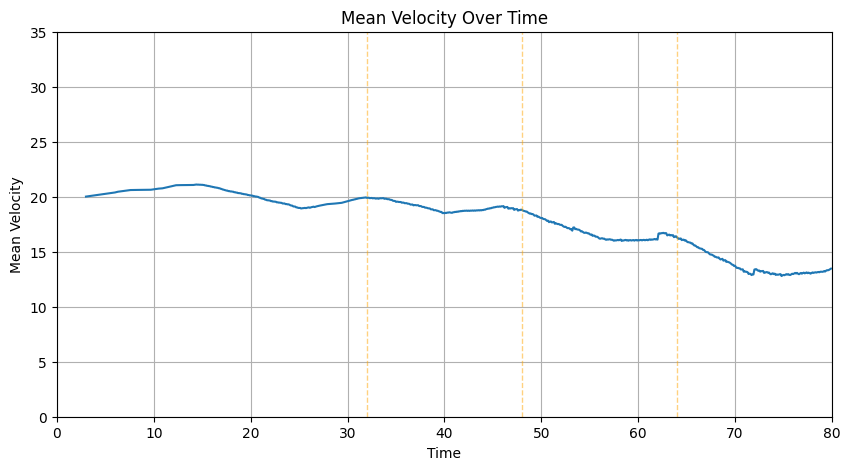

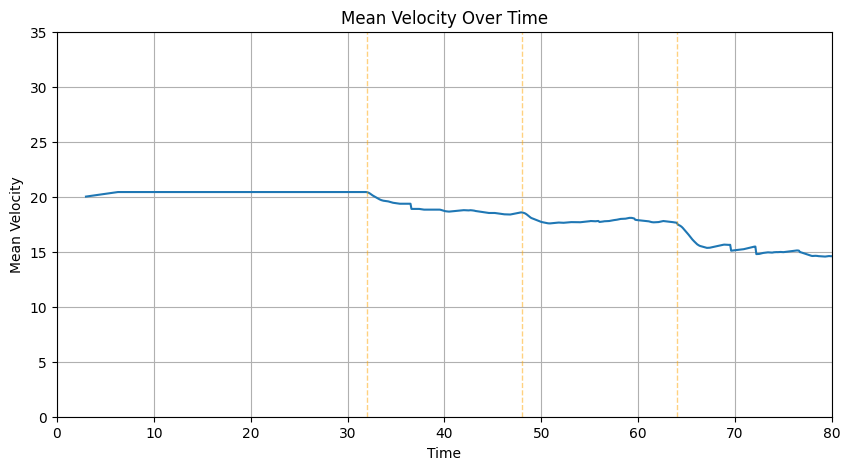

In [20]:
vfr_simulation.plot_v_mean_log("./images/vfr/v_mean_log_vfr.png")
simulation.plot_v_mean_log("./images/dfr/v_mean_log_dfr.png")

In [15]:
def plot_v_mean_log(path, v_mean_dfr, v_mean_vfr):
    v_mean_log = v_mean_dfr
    # event_flgが"noise"のデータポイントを抽出する
    noise_time = [entry["time"]
                  for entry in v_mean_log if entry.get("event_flg") == "noise"]
    noise_v_mean = [entry["v_mean"]
                    for entry in v_mean_log if entry.get("event_flg") == "noise"]
    noise_times = [entry["time"]
                   for entry in v_mean_vfr if entry.get("event_flg") == "noise"]

    # timeとv_meanをそれぞれリストに抽出する
    time = [entry["time"] for entry in v_mean_log]
    v_mean = [entry["v_mean"] for entry in v_mean_log]
    v_mean_vfr = [entry["v_mean"] for entry in v_mean_vfr]

    # グラフを描画する
    plt.figure(figsize=(10, 8))
    plt.plot(time, v_mean, label="DFR",)
    plt.plot(time, v_mean_vfr, label="VFR")

    # ノイズのデータポイントを赤丸でプロットする
    # plt.scatter(noise_time, noise_v_mean, color='red', label='Noise Event', zorder=5)

    # ノイズ発生タイミングに赤線
    for n in noise_times:
        plt.axvline(x=n, color='orange', linestyle='--', alpha=0.5,
                    linewidth=1)

    # グラフのタイトルとラベルを設定する
    plt.title('Mean Velocity Over Time')
    plt.xlabel('Time')
    plt.ylabel('Mean Velocity')

    plt.xlim(0, 85)
    plt.ylim(0, 32)
    plt.legend()

    # グリッドを表示する
    plt.grid(True)
    plt.savefig(path)

plot_v_mean_log("./images/dfr/v_mean_log_dfr_vs_vfr.png", simulation.v_mean_log, vfr_simulation.v_mean_log)

NameError: name 'simulation' is not defined

In [20]:
# Fundamental Diagram作るように一気にやるためのコードを書く. 
# DENSITY_LIST = [20, 18, 16, 14, 12,10, 8,6,5,4,3.5, 3 ,2.8, 2.6, 2.5, 2, 1.8, 1.6, 1.5, ]
DENSITY_LIST = [20, 18]
COMMUNICATION_SPEED = 0.2
results = []
arrival_time_log = []
import sys
import io
from collections import defaultdict


def collect_v_mean_by_density(data):
    density_groups = defaultdict(list)
    for entry in data:
        density_groups[entry['density']].append(entry['v_mean'])
    
    # 各densityのv_meanの平均を計算
    density_mean_v_mean = {density: sum(v_means)/len(v_means) for density, v_means in density_groups.items()}
    return density_mean_v_mean


for idx, density in enumerate(DENSITY_LIST):
    print(f"d={density}")

    arrival_times = generate_arrival_times(CAR_NUM, density, TOTAL_TIME)
    arrival_times.append(TOTAL_TIME + TTC +0.2)
    CARS = [Cars(arrival_time=time, index=index, v_mean=MEAN_SPEED, v_max = MAX_SPEED, a_max=MAX_ACC, a_min=MAX_ACC)
              for index, time in enumerate(arrival_times)]
    arrival_time_log.append({"density": density, "arrival_times":arrival_times})

    # まずはDFR
    reservation_table = ReservationTable(waypoints = WAYPOINTS, global_params = {"DESIRED_TTC":TTC})
    register_initial_eta(CARS)
    # 標準出力を無効化
    original_stdout = sys.stdout
    sys.stdout = io.StringIO()

    dfr_simulation = DFRSimulation(TOTAL_TIME = TOTAL_TIME, TIME_STEP = TIME_STEP, TOTAL_LENGTH = TOTAL_LENGTH, CARS = CARS, \
                          reservation_table = reservation_table, DENSITY=DENSITY, COMMUNICATION_SPEED=COMMUNICATION_SPEED)
    result = {
        "type":"dfr",
        "density": density,
        "v_mean":None,
    }

    try:
        dfr_simulation.conduct_simulation(should_plot=False)
        dfr_log = dfr_simulation.v_mean_log
        v_mean_by_density = collect_v_mean_by_density(dfr_log)
        result["v_mean"] = v_mean_by_density

    except:
        pass

    results.append(result)
    sys.stdout = original_stdout


    # 続いてVFR
    result = {
        "type":"vfr",
        "density": density,
        "v_mean":None,
    }
    try:
        print("===TRYING VFR===")
        original_stdout = sys.stdout
        sys.stdout = io.StringIO()
        vfr_simulation = VFRSimulation(TOTAL_TIME = TOTAL_TIME, TIME_STEP = TIME_STEP, TOTAL_LENGTH = TOTAL_LENGTH, dfr_reference=dfr_simulation, car_params=car_params)
        vfr_simulation.conduct_simulation(should_plot=False)
        vfr_log = vfr_simulation.v_mean_log
        v_mean_by_density = collect_v_mean_by_density(vfr_log)
        result["v_mean"] = v_mean_by_density
        
    except: 
        pass
    finally:
        # 標準出力を元に戻す
        sys.stdout = original_stdout
    results.append(result)
print("DONE!")


SyntaxError: expected 'except' or 'finally' block (1134946522.py, line 54)

In [17]:
sys.stdout = original_stdout
print(results)

In [18]:
print(arrival_time_log)

In [26]:
results_to_analyze = results

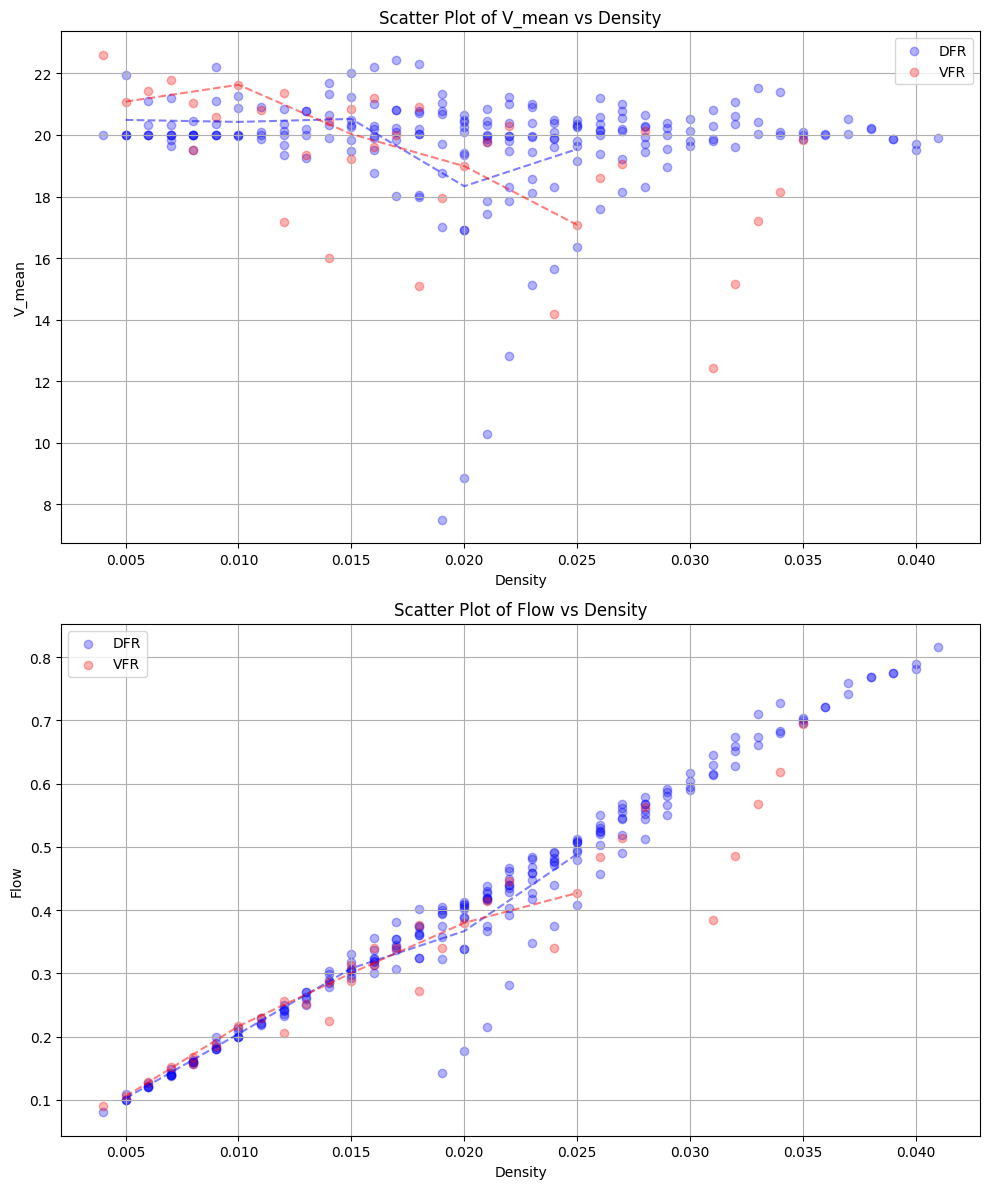

In [27]:
dfr_data = {'density': [], 'v_mean': [], 'flow': []}
vfr_data = {'density': [], 'v_mean': [], 'flow': []}

# 各densityに対するv_meanの平均を計算するための辞書
dfr_density_v_mean = defaultdict(list)
vfr_density_v_mean = defaultdict(list)

for entry in results:
    if entry['v_mean'] is not None:
        for density, v_mean in entry['v_mean'].items():
            if entry['type'] == 'dfr':
                dfr_data['density'].append(density)
                dfr_data['v_mean'].append(v_mean)
                dfr_data['flow'].append(density * v_mean)
                dfr_density_v_mean[density].append(v_mean)
            elif entry['type'] == 'vfr':
                vfr_data['density'].append(density)
                vfr_data['v_mean'].append(v_mean)
                vfr_data['flow'].append(density * v_mean)
                vfr_density_v_mean[density].append(v_mean)

plot_densities = [0.005, 0.010, 0.015, 0.020, 0.025]

# 各指定されたdensityごとのv_meanとflowの平均を計算
dfr_density_avg_v_mean = {density: np.mean(dfr_density_v_mean[density]) for density in plot_densities if density in dfr_density_v_mean}
vfr_density_avg_v_mean = {density: np.mean(vfr_density_v_mean[density]) for density in plot_densities if density in vfr_density_v_mean}

dfr_density_avg_flow = {density: density * np.mean(dfr_density_v_mean[density]) for density in plot_densities if density in dfr_density_v_mean}
vfr_density_avg_flow = {density: density * np.mean(vfr_density_v_mean[density]) for density in plot_densities if density in vfr_density_v_mean}


# ソートしてリスト化
dfr_density_sorted_v_mean = sorted(dfr_density_avg_v_mean.items())
vfr_density_sorted_v_mean = sorted(vfr_density_avg_v_mean.items())

dfr_density_sorted_flow = sorted(dfr_density_avg_flow.items())
vfr_density_sorted_flow = sorted(vfr_density_avg_flow.items())

# プロット
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# v_mean vs density
axs[0].scatter(dfr_data['density'], dfr_data['v_mean'], color='blue', label='DFR', alpha=0.3)
axs[0].scatter(vfr_data['density'], vfr_data['v_mean'], color='red', label='VFR', alpha=0.3)

# 平均線を引く
axs[0].plot([item[0] for item in dfr_density_sorted_v_mean], [item[1] for item in dfr_density_sorted_v_mean], color='blue', linestyle='--', alpha=0.5)
axs[0].plot([item[0] for item in vfr_density_sorted_v_mean], [item[1] for item in vfr_density_sorted_v_mean], color='red', linestyle='--', alpha=0.5)


axs[0].set_xlabel('Density')
axs[0].set_ylabel('V_mean')
axs[0].set_title('Scatter Plot of V_mean vs Density')
axs[0].legend()
axs[0].grid(True)

# flow vs density
axs[1].scatter(dfr_data['density'], dfr_data['flow'], color='blue', label='DFR', alpha=0.3)
axs[1].scatter(vfr_data['density'], vfr_data['flow'], color='red', label='VFR', alpha=0.3)

# 平均線を引く
axs[1].plot([item[0] for item in dfr_density_sorted_flow], [item[1] for item in dfr_density_sorted_flow], color='blue', linestyle='--', alpha=0.5)
axs[1].plot([item[0] for item in vfr_density_sorted_flow], [item[1] for item in vfr_density_sorted_flow], color='red', linestyle='--', alpha=0.5)


axs[1].set_xlabel('Density')
axs[1].set_ylabel('Flow')
axs[1].set_title('Scatter Plot of Flow vs Density')
axs[1].legend()
axs[1].grid(True)

# グラフを表示
plt.tight_layout()
plt.savefig(f"./images/n_period={NOISE_PERIOD}_n_forecast={NOISE_FORECAST_TIME}_n_freq={NOISE_FREQUENCY}")
plt.show()


In [16]:
vlog = simulation.v_mean_log
print(vlog[300:340])
table = simulation.reservation_table.eta_table
print(table[table["car_idx"] == 0])

[{'time': 33.0, 'v_mean': 20.04736842105263, 'density': 0.019, 'event_flg': None}, {'time': 33.1, 'v_mean': 20.031578947368423, 'density': 0.019, 'event_flg': None}, {'time': 33.2, 'v_mean': 20.01578947368421, 'density': 0.019, 'event_flg': None}, {'time': 33.300000000000004, 'v_mean': 20.0, 'density': 0.019, 'event_flg': None}, {'time': 33.4, 'v_mean': 19.98421052631579, 'density': 0.019, 'event_flg': None}, {'time': 33.5, 'v_mean': 19.968421052631577, 'density': 0.019, 'event_flg': None}, {'time': 33.6, 'v_mean': 19.95263157894737, 'density': 0.019, 'event_flg': None}, {'time': 33.7, 'v_mean': 19.936842105263157, 'density': 0.019, 'event_flg': None}, {'time': 33.800000000000004, 'v_mean': 19.92105263157895, 'density': 0.019, 'event_flg': None}, {'time': 33.9, 'v_mean': 19.905263157894737, 'density': 0.019, 'event_flg': None}, {'time': 34.0, 'v_mean': 19.905263157894737, 'density': 0.019, 'event_flg': None}, {'time': 34.1, 'v_mean': 19.905263157894737, 'density': 0.019, 'event_flg': N

[20.300000000000004, 20.599999999999994, 20.9, 21.20000000000001, 21.500000000000004, 21.800000000000015, 22.10000000000001, 22.40000000000002, 22.699999999999996, 23.000000000000007, 23.30000000000002, 23.599999999999994, 23.900000000000006, 24.200000000000017, 24.499999999999993, 24.80000000000004, 24.933763884510753, 25.00205455537177, 25.045066351248195, 25.078284478181345, 25.107649150798323, 25.13543427568102, 25.162509497197192, 25.189207542893186, 25.21565612084416, 25.241904739377077, 25.26797310634123, 25.29386957926704, 25.319598191088915, 25.34516132271463, 25.37056071867525, 25.39579787278342, 25.420874174509436, 25.44579096457028, 25.470549556103492, 25.49515124281058, 25.51959730216808, 25.54388899677207, 25.568027574976497, 25.592014271262684, 25.615850306503347, 25.639536888187706, 25.66307521062626, 25.686466455148178, 25.709711790291863, 25.73281237199282, 26.032812371992833, 26.332812371992844, 26.632812371992856, 26.932812371992867, 27.23281237199288, 27.5328123719

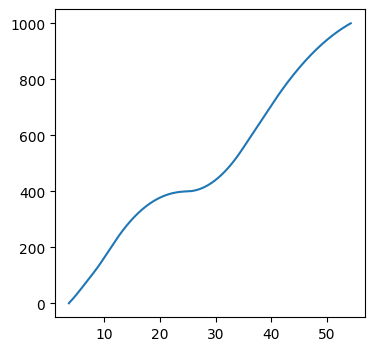

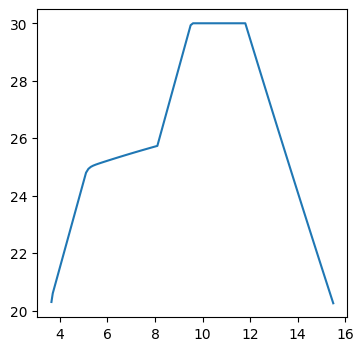

In [15]:
cars = vfr_simulation.CARS
car_0 = cars[1]
xcors = car_0.xcorList
plt.figure(figsize = (4,4))
plt.plot(car_0.timeLog, car_0.xcorList)

vList = []
for i in range(len(xcors)-1):
    v = (xcors[i+1] - xcors[i]) * 10
    vList.append(v)

print(vList[:120])

plt.figure(figsize=(4,4))
plt.plot(car_0.timeLog[:120], vList[:120])



In [16]:
# 動画作成
import cv2
import os
import re

# カレントディレクトリを取得
current_dir = os.getcwd()
# 画像フォルダのパス
image_folder = os.path.join(current_dir, 'images/dfr')
video_file = f'output_video_TTC={TTC}.mp4'

# 正規表現でファイル名からtの値を抽出
def extract_t(filename):
    match = re.search(r't=(\d+\.\d+)', filename)
    if match:
        return float(match.group(1))
    return None

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
images = sorted(images, key=lambda x: extract_t(x))

# 画像から動画を作成
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

# 動画ライターを設定
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter(video_file, fourcc, 5, (width, height))  # フレームレートを5fpsに設定

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

# リソースを解放
cv2.destroyAllWindows()
video.release()

# ここから下はDebug用のセル

In [27]:
# ↑の DFRのシミュレーションでつっかえた時のデバッグ用のセル. これは適宜上に上げて良い

car_1 = CARS[14]
print("ETA",car_1.my_etas)
print("===  acc_itinerary =====")
print(car_1.acc_itinerary)
print(car_1.xcor)
print(car_1.v_x)

# print("acc:",car.acc_itinerary)
# table = simulation.reservation_table.eta_table
# print(table[table["car_idx"]<=4])

IndexError: list index out of range

In [7]:
import sys 
sys.path.append("../")
from utils.calc_distance_from_acc_itinerary import calc_distance_from_acc_itinerary
acc_itinerary = [{'acc': 0, 't_start': 29.113823476836664, 'v_0': 20, 't_end': 32.6, 'x_start': 0}, {'t_start': 32.6, 'acc': -3, 'v_0': 20.0, 't_end': 33.1}, {'t_start': 33.1, 'acc': 0, 'v_0': 18.5, 't_end': 45.120270270270275}, {'t_start': 45.120270270270275, 'acc': -3, 'v_0': 18.5, 't_end': 45.620270270270275}, {'t_start': 45.620270270270275, 'acc': 0, 'v_0': 17.0, 't_end': 52.745270270270275}, {'t_start': 52.745270270270275, 'acc': 2, 'v_0': 17.0, 't_end': 53.745270270270275}, {'t_start': 53.745270270270275, 'acc': 0, 'v_0': 19.0, 't_end': 56.804093799682036}, {'t_start': 56.804093799682036, 'acc': 2, 'v_0': 19.0, 't_end': 60.804093799682036}, {'t_start': 60.804093799682036, 'acc': 0, 'v_0': 27.0, 't_end': 60.90316500711238}]
x = calc_distance_from_acc_itinerary(acc_itinerary, 53)
print(x)

436.1188231038803


In [6]:
def calc_x_at_pointed_time(pointed_time, carObj, current_time):
    acc_itinerary = carObj.acc_itinerary
    car_x = carObj.xcor
    # print(carObj.xcor, carObj.acc_itinerary)
    v_0 = carObj.v_x
    acc_itinerary_with_tend = carObj.acc_itinerary
    # print(f"carId: {carObj.car_idx}, acc_itinerary: {acc_itinerary_with_tend}")

    if len(acc_itinerary_with_tend) < 1:
        raise ValueError("acc_itinerary is empty")
    if len(acc_itinerary_with_tend) == 1:
        delta_t = pointed_time - current_time
        delta_x = v_0 * delta_t + 0.5 * acc_itinerary_with_tend[0]["acc"] * delta_t**2 + car_x
        return delta_x
    
    # 長さ2以上の場合
    for idx, accObj in enumerate(acc_itinerary_with_tend):
        if accObj["t_end"] < current_time:
            continue

        # この区間を全うできる場合.
        elif accObj["t_end"] <= pointed_time:
            delta_t = accObj["t_end"] - accObj["t_start"]
            if accObj["t_start"] < current_time:
                delta_t = accObj["t_end"] - current_time
            delta_x = v_0 * delta_t + 0.5 * accObj["acc"] * delta_t**2
            car_x += delta_x
            v_0 += delta_t * accObj["acc"]

        # 一番最後の区間の場合
        elif idx == len(acc_itinerary) - 1 or accObj["t_end"] > pointed_time:
            delta_t = pointed_time - accObj["t_start"]
            if accObj["t_start"] < current_time:
                delta_t = accObj["t_end"] - current_time
            delta_x = v_0 * delta_t + 0.5 * accObj["acc"] * delta_t**2
            car_x += delta_x
            break
        else:
            print(accObj, current_time, pointed_time, carObj.car_idx)
            raise ValueError("Something wrong")

    return car_x

calc_x_at_pointed_time(53, car_1, 48)

442.42488723520705